# Information Retrieval
***
## | Latent Dirichlet Allocation |

Damien Draime - Mar 19

### Introduction

In **Topic Modelling**, a document is modeled as a mixture of topics. Those topics can not be observed directly and will only emerge at the end of the topic modelling process. Lately, there is a large interest in probabilistic topcial models such as **probabilistic Latent Semantic Analysis (pLSA)** and **Latent Dirichlet Allocation (LDA)**.<br>
**Latent Dirichlet Allocation** assumes that each document can be described by a distribution of topics and each topic can be described by a distribution of words. LDA is a generative statistical model.<br> Trained on a large corpus, this model learns:
- per-topic word distributions
- per-document topic distributions 

<br> *Note that this approach can be used on other data than just documents and words. We could for example apply it on employees and skills, or buyers and items bought.*<br><br>
 - [Motivation](#Motivation)
 - [LDA](#LDA)
     - [Decomposition](#Decomposition)
     - [Generative model](#Generative-model)
     - [Dirichlet priors](#Dirichlet-priors)
 - [Training](#Training)
     - [Gibbs sampling](#Gibbs-sampling)
 - [LDA for retrieval](#LDA-for-retrieval)
 - [Examples](#Examples)


***

*Based on __[Blei and al. - Latent Dirichlet Allocation](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)__, and __[KU Leuven's Text-Based Information Retrieval - Lecture 04](https://p.cygnus.cc.kuleuven.be/bbcswebdav/pid-22306777-dt-content-rid-175870631_2/courses/B-KUL-H02C8a-1819/Chapter4-AdvancedRepresentations-Part2.pdf)__.*

## Motivation
Let's look at a toy example made of a collection of D documents and a vocabulary of V words. For this example, D=6, and V=5.

In [7]:
import numpy as np
import pandas as pd
pd.set_option('precision', 3)
A = pd.read_csv('toy_example.csv',index_col=0).transpose()
A

index,river,stream,bank,money,loan
document 1,3,2,1,0,0
document 2,2,3,0,0,0
document 3,0,0,2,4,3
document 4,4,2,2,0,0
document 5,0,1,2,1,2
document 6,0,2,3,4,1


We have here a matrix __A__<sub>D x V</sub>. Each column refers to a specific word, each row to a document. A<sub>ij</sub> indicates the frequency of the word j in the document i (*tf<sub>ij</sub>*).<br>
*E.g.: the word `stream` appears in all documents, except for `document 3`*<br><br>
Intuitively, we notice that documents 1,2, and 4 have the same underlying topic ("river" related). We could also argue that the other documents are related to "finance". Hence we can identify that there are two topics/concepts.<br><br>
Instead of representing the documents as a mixture of words in order to find which documents are similar, we could try to aggregate the words to different "buckets". We could then represent documents as a mixture of those buckets/**topics**. Each document would then be described by a topic distribution. Note that these topics are not directly observable (i.e. latent). <br>One can view these topics as clusters and the probabilities as a proportion of cluster membership. In that case, LDA performs a soft clustering of the documents and the words. These **fuzzy memberships** provide a more nuanced way of defining the similarity between two documents. This clustering also allows us to perform a **dimensionality reduction**. The documents are now mapped to a lower dimensional latent/hidden topic space.<br>
LDA is also convienent to **uncover themes** lurking in the documents. As we will see in the last section, this approach can be applied to multiple types of data, and not only to  documents and words.
![figure 01 - Latent topics](Latent-topics.jpg)<br>

## LDA
### Decomposition
When Latent Dirichlet Allocation is applied on a *document-word* matrix such as __A__<sub>D x V</sub>, the matrix will be decomposed into a *topic-word* matrix and a *document-topic* matrix. The topic-word matrix will be of dimension KxV while the document-topic matrix's dimension will be DxK. <br> This parameter $K$ will be defined by the user prior to the training phase and signals that we expect **K latent topics** to be discovered in the corpus.<br>
Those topics will be represented by a distribution of words. Let's have a look at the two topics that we want to extract from our toy example:

In [1]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

k = 2 #Parameter defining the number of topics we would like to discover

corpus = [
             ['river','bank','river','stream','river','stream'], #Document 1
             ['stream','river','stream','river','stream'], #Document 2
             ['money','loan','bank','money','money','loan','bank','money','loan'], #Document 3
             ['river','bank','river','stream','river','stream','bank','river'], #Document 4
             ['stream','bank','money','loan','bank','loan'], #Document 5
             ['stream','bank','money','loan','bank','stream','money','money','bank','money'] #Document 6
         ]
vocabulary = Dictionary(corpus)
corpus_bow = [vocabulary.doc2bow(document) for document in corpus]

lda = LdaModel(corpus_bow, id2word = vocabulary, num_topics = k)
for topic_idx, desc in lda.print_topics():
    print('Topic #{} \n    \--> description: {}\n'.format(topic_idx, desc))

Topic #0 
    \--> description: 0.262*"bank" + 0.238*"stream" + 0.219*"money" + 0.175*"loan" + 0.106*"river"

Topic #1 
    \--> description: 0.230*"river" + 0.221*"stream" + 0.215*"bank" + 0.200*"money" + 0.134*"loan"



As you have noticed, we now have two topics. For each one of them we have a distribution of words which can be interpreted as how important is each word with regard to that specific topic. The higher the number in front of the word, the more meaningful is the word for that topic. As you can see, one topic is related to "finance" and the other one is more related to "river".<br> This number $K$ of topics has been fixed upfront by the user. It is not always straightforward to find the number of latent topics in a corpus. As it is not always clear how many clusters should a K-Means algorithm generate. Hence, as it is done when using K-Means algorithm, we often rerun the LDA multiple times with different values for the parameter $K$ to see what fits best the data.<br>
You might have also noticed that LDA does not care about the words' order in each document. Indeed, in this implementation, we have used a **bag-of-words** feature representation to represent each document. Thus the context surrounding each word is lost.<br>
Finally, if you were to rerun this cell multiple times, you will notice that the distribution of words in a topic is not always similar to the previous one you had. This is due to the way we train LDA. As LDA is a **stochastic method**, we might end up in different local maximum. However it is important to notice that the sum of the probabilities for each word for a given topic will always be 1.

The results obtained above can actually be represented by a matrix. This **topic-word** matrix is often referred to as $\phi$. Each row $\phi^k$ represents a topic and indicates which words (in the columns) are important for describing the topic. Each row is thus a multinomial distribution over words for the topic $z_k$ : $\phi^k = P(w|z_k)$.

In [8]:
phi = lda.get_topics()
print('Phi: a KxV matrix')
pd.DataFrame(phi, index=['Topic 0','Topic 1'], columns=['bank','river','stream','loan','money'])

Phi: a KxV matrix


,bank,river,stream,loan,money
Topic 0,0.262,0.106,0.238,0.175,0.219
Topic 1,0.215,0.230,0.221,0.134,0.200


The second element of the decomposition of the original document-word matrix is the **document-topic** matrix, usually referred to as $\theta$. Each row $\theta^j$ of this matrix indicates how important are the different topics for the document. Hence rows represent documents, while columns represent topics. Each row is thus a multinomial distribution over topics for the document $d_j$ : $\theta^j = P(z|d_j)$.

In [9]:
theta = np.array([[0,0]])
_theta = lda.get_document_topics(corpus_bow)
for i in range(len(corpus)):
    theta = np.concatenate((theta,[[_theta[i][0][1],_theta[i][1][1]]]))
theta = np.delete(theta,0,0)
print('Theta: a DxK matrix')
pd.DataFrame(theta, index=['Document 1','Document 2','Document 3','Document 4','Document 5','Document 6'], columns=['Topic 0','Topic 1'])

Theta: a DxK matrix


,Topic 0,Topic 1
Document 1,0.097,0.903
Document 2,0.118,0.882
Document 3,0.770,0.207
Document 4,0.077,0.923
Document 5,0.796,0.208
Document 6,0.641,0.398


Compare this with our original matrix and the intuition we had. From $\theta_3$ we can clearly see that `Topic 0` (i.e. "finance") is more important for `Document 3`. Alternatively, $\theta_4$ indicates that `Topic 1` (i.e. "river") is more important for `Document 4`.

In Natural Language Processing, we are interested in estimating:<br>
$P(d_j,w_i) = P(d_j)P(w_i|d_j)$
<br>and in the context of a language retrieval model, espcially in:<br>
$P(w_i|d_j) = \sum_{k=1}^K P(w_i|z_k)P(z_k|d_j)$<br>
 where $P(w_i|z_k) = \phi_{k,i}$, and $P(z_k|d_j) = \theta_{j,k}$<br><br>
 We can now derive $P(w|d)$ to see which words are likely to be generated by each document:

In [10]:
theta_phi = np.dot(theta,phi)
pd.DataFrame(theta_phi,index=['Document 1','Document 2','Document 3','Document 4','Document 5','Document 6'], columns=['bank','river','stream','loan','money'])

,bank,river,stream,loan,money
Document 1,0.219,0.218,0.223,0.138,0.202
Document 2,0.220,0.215,0.223,0.139,0.202
Document 3,0.246,0.129,0.229,0.163,0.210
Document 4,0.218,0.221,0.222,0.137,0.202
Document 5,0.253,0.132,0.235,0.168,0.216
Document 6,0.253,0.160,0.240,0.166,0.220


As you can see `Document 4` is likely to generate the words `river` and `stream` in comparison with the words `money` and `loan`. This is due to the topic distribution for that document as well as the word distribution for those topics.<br>
Notice also how some rows are really similar to each other. We now have a matrix of **lower rank** (i.e. rank=$K$=2) than the original 'document-word' matrix.

### Generative model
As said previously, the Latent Dirichlet Allocation is a **generative probabilistic model**. It is an unsupervised model in which the semantic properties of words and documents are expressed in terms off topics. As such, it assumes that a collection of $K$ latent topics can be discovered and used to describe the elements of the corpus. <br>
The process used by LDA to generate each document of words is:
> for each topic k $\in$ K:
>> sample $\phi_k$ from $Dirichlet(\beta)$

>for each document $d$ $\in$ D:<br>
>> sample $\theta_d$ from $Dirichlet(\alpha)$<br>
>> for each word position n in $d_j \in N_d$:<br>
>>> sample $z_{dn}$ from $Multinomial(\theta_d)$<br>
>>> sample $w_{dn}$ from $Multinomial(\phi_k,z_{dn})$

Here is the **Bayesian representation** of LDA:
![figure 01 - LDA graphical model](LDA-model.jpg)
*where the colored nodes are the Dirichlet priors, the gray node is the the only observed variable, all other variables are latent and thus their values can only be inferred by observing the outcome of the observed vairables*<br><br>
This means that to generate a document $d$ with $Nd$ words, we first need to sample $k$ distributions $\phi_k$ from the Dirichlet prior $\beta$. This gives us the matrix $\phi$ where each row indicates the word distribution for a specific topic. Then for the document $d$ we sample once from the Dirichlet prior $\alpha$, in order to get the vector $\theta_d$, which indicates the topic distribution for that document. Since the document $d$ containts $Nd$ words, for each position $n$ in $Nd$, we retrieve from a Multinomial on $\theta_d$, the topic from which this word in position $n$ should be generated. Finally for each word position $n$, given $\phi_k$ and $z_{dn}$ , we sample a word to fill the slot $n$. 

### Dirichlet priors
The priors capture our initial uncertainty about the parameters. Since those are **conjugate priors** of a multinomial distribution, we also call them **Dirichlet priors**. <br>
$\theta$ is a Dirichlet distribution which is characterized by a set of hyper-parameters $\alpha_1$, $\alpha_2$, ..., $\alpha_k$. <br>
$\theta \backsim Dirichlet(\alpha_1, \alpha_2, ..., \alpha_k)$ <br>
Those hyper-parameters are the Dirichlet priors. $\alpha_i$ can be seen as prior observaation count for the number of times a topix $z_i$ is sampled in a document *before having observed any actual words from that document*.
For each document is gives the topic distribution.<br>
Similarly, we have the Dirichlet distribution $\phi$ which is characterized by the vector $\beta = (\beta_1, \beta_2, ..., \beta_V)$:<br>
$\phi \backsim Dirichlet(\beta_1, \beta_2, ..., \beta_V)$ <br>
where $\beta_i$ is a prior observation count on the number of times a vocabulary word $w_i$ is sample from a topic *before any actual observations*.<br><br>
We usually work with **symmetric Dirichlet priors** for $\alpha$ and $\beta$. This means that the elements making up the vectors $\alpha$ and $\beta$ all share the same value. There are not good estimates for those priors that will work well in all situations, as those estimates will depend on the number of topics $K$ and the vocabulary size $V$. However, note that increasing $\alpha$ favors documents with a mixture of topics, while decreasing it is more likely to generate documents that are made of few topics. Similarily, decreasing $\beta$ is likely to generate $\phi$ where a few words are important to define the topic, while increasing it favors topics where less and less words are crucial for the topic.<br><br> 
Let's play with this Dirichlet distribution to get a better feeling for it. Below we assume that there are only 3 topics. Adjust the values of $\alpha$ to observe what kind of topic-distributions are generated.Each corner of the triangle is a topic. Each generated dot is a topic distribution for a document (the coordonates of a datapoint indicate the topic distribution for that document). For example, if the coordinates are (0.3, 0.1, 0.6) it highlights that the probabilities of the document to contain words belonging to the topics 1, 2, and 3 are 0.3, 0.1, and 0.6, respectively. 

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

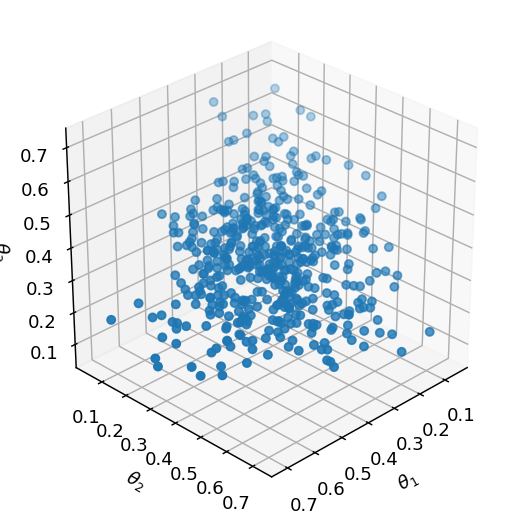

In [13]:
def dirichlet(alpha1,alpha2,alpha3):
    theta = np.random.dirichlet([alpha1,alpha2,alpha3],500)
    fig = plt.figure(figsize=(5, 5), dpi=130)
    ax = plt.gca(projection='3d')
    ax.scatter(theta[:, 0], theta[:, 1], theta[:, 2])
    ax.view_init(azim=45)
    ax.set_xlabel(r'$\theta_1$')
    ax.set_ylabel(r'$\theta_2$')
    ax.set_zlabel(r'$\theta_3$')
    plt.show()

dirichlet(5,5,5) # Adjust the parameters here

Comparatively, the Dirichlet prior $\beta$ is KxV matrix. For each topic is gives the word distribution.

## Training
But how do we train those LDAs ? There exists multiple approaches, such as the **Expectation-Maximization algorithm**, the **Gibbs sampling**, and the **Variational inference**. The Expectation-Maximization algorithm is an iterative method to estimate the probability of unobserved, latent variables until a local optimum is obtained. The Gibbs sampling method updates parameters sample-wise. And the Variational inference approximates the model by an easier one. <br>
For this notebook, we will focus on the Gibbs sampling. But note that the LDA model implemented in the library Gensim that we have used above uses the E-M algorithm.<br>
### Gibbs sampling

For inference on a new document, the problem boils down to infer $\theta$ given $\alpha$, $\beta$ and $\phi$